# Amazon Fashion Reviews - Analysis & Visualization

This notebook performs comprehensive Exploratory Data Analysis (EDA) on the Amazon Fashion reviews dataset using SQL queries via dbutils and advanced analysis with Polars.

## Overview
- **Dataset**: Amazon Fashion Reviews (2.5M+ records)
- **Database**: ClickHouse with optimized schema
- **Tools**: dbutils (SQL), Polars (Data Analysis), Matplotlib/Seaborn (Visualization)
- **Focus**: Extract meaningful insights, patterns, and distributions

## Analysis Objectives
1. **Data Quality Assessment**: Missing values, data types, completeness
2. **Rating Analysis**: Distribution, trends, patterns
3. **Temporal Analysis**: Review patterns over time
4. **Product Analysis**: Most reviewed products, rating correlations
5. **User Behavior**: Review patterns, helpfulness analysis
6. **Text Analysis**: Review sentiment and length patterns
7. **Business Insights**: Key findings and recommendations

## Prerequisites
- ClickHouse running with amazon.reviews table populated
- Python packages: dbutils, polars, matplotlib, seaborn, pandas
- .env file with database credentials


## 1. Setup and Imports

Import required libraries and configure the environment for analysis.


In [ ]:
# Import required libraries
import sys
sys.path.append('/home/ubuntu/LONGIN-DUSENGEYEZU-ASSIGNEMNT/python-dbutils')

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Database connectivity
from decouple import AutoConfig
from dbutils import Query

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")
print("📊 Matplotlib and Seaborn configured for visualization")
print("🔧 dbutils ready for ClickHouse connectivity")
print("⚡ Polars ready for high-performance data analysis")


✅ Libraries imported successfully
📊 Matplotlib and Seaborn configured for visualization
🔧 dbutils ready for ClickHouse connectivity
⚡ Polars ready for high-performance data analysis


In [4]:
# Setup ClickHouse connection using dbutils
config = AutoConfig(search_path='/home/ubuntu/LONGIN-DUSENGEYEZU-ASSIGNEMNT/.env')

clickhouse = Query(
    db_type='clickhouse',
    db=config('db_clickhouse_db'),
    db_host=config('db_clickhouse_host'),
    db_port=int(config('db_clickhouse_port')),  # Convert to int
    db_user=config('db_clickhouse_user'),
    db_pass=config('db_clickhouse_pass'),
)

print("✅ ClickHouse connection established")
print(f"📊 Connected to database: {config('db_clickhouse_db')}")
print(f"👤 User: {config('db_clickhouse_user')}")
print(f"🌐 Host: {config('db_clickhouse_host')}:{config('db_clickhouse_port')}")

# Test connection and show data count
test_result = clickhouse.sql_query(sql='SELECT COUNT(*) as total FROM amazon.reviews')
total_reviews = test_result.to_pandas().iloc[0, 0]  # Convert to Pandas first, then extract value
print(f"📈 Total reviews in database: {total_reviews:,}")
print(f"🎯 Ready for analysis!")


✅ ClickHouse connection established
📊 Connected to database: amazon
👤 User: longin
🌐 Host: localhost:9000
📈 Total reviews in database: 2,531,859
🎯 Ready for analysis!


## 2. Data Quality Assessment

First, let's assess the overall data quality and get basic statistics about our dataset.


In [5]:
# Basic data quality assessment using SQL
print("🔍 DATA QUALITY ASSESSMENT")
print("="*50)

# Get basic counts and statistics (using timestamp to calculate dates)
basic_stats_query = """
SELECT 
    COUNT(*) as total_reviews,
    COUNT(DISTINCT asin) as unique_products,
    COUNT(DISTINCT user_id) as unique_users,
    COUNT(DISTINCT toYear(toDate(timestamp / 1000))) as years_covered,
    MIN(toDate(timestamp / 1000)) as earliest_review,
    MAX(toDate(timestamp / 1000)) as latest_review
FROM amazon.reviews
"""

basic_stats = clickhouse.sql_query(sql=basic_stats_query)
# Extract values from Polars DataFrame
total_reviews = basic_stats.to_pandas().iloc[0, 0]
unique_products = basic_stats.to_pandas().iloc[0, 1]
unique_users = basic_stats.to_pandas().iloc[0, 2]
years_covered = basic_stats.to_pandas().iloc[0, 3]
earliest_review = basic_stats.to_pandas().iloc[0, 4]
latest_review = basic_stats.to_pandas().iloc[0, 5]

print(f"📊 Basic Statistics:")
print(f"   Total Reviews: {total_reviews:,}")
print(f"   Unique Products: {unique_products:,}")
print(f"   Unique Users: {unique_users:,}")
print(f"   Years Covered: {years_covered}")
print(f"   Date Range: {earliest_review} to {latest_review}")
print()

# Check for missing values in key columns
missing_values_query = """
SELECT 
    COUNT(*) - COUNT(rating) as missing_ratings,
    COUNT(*) - COUNT(title) as missing_titles,
    COUNT(*) - COUNT(text) as missing_text,
    COUNT(*) - COUNT(asin) as missing_asin,
    COUNT(*) - COUNT(user_id) as missing_user_id,
    COUNT(*) - COUNT(timestamp) as missing_timestamp
FROM amazon.reviews
"""

missing_stats = clickhouse.sql_query(sql=missing_values_query)
print(f"🔍 Missing Values Check:")
print(f"   Missing Ratings: {missing_stats.to_pandas().iloc[0, 0]:,}")
print(f"   Missing Titles: {missing_stats.to_pandas().iloc[0, 1]:,}")
print(f"   Missing Text: {missing_stats.to_pandas().iloc[0, 2]:,}")
print(f"   Missing ASIN: {missing_stats.to_pandas().iloc[0, 3]:,}")
print(f"   Missing User ID: {missing_stats.to_pandas().iloc[0, 4]:,}")
print(f"   Missing Timestamps: {missing_stats.to_pandas().iloc[0, 5]:,}")
print()

# Data completeness percentage
completeness_query = f"""
SELECT 
    ROUND((COUNT(rating) * 100.0 / {total_reviews}), 2) as rating_completeness,
    ROUND((COUNT(title) * 100.0 / {total_reviews}), 2) as title_completeness,
    ROUND((COUNT(text) * 100.0 / {total_reviews}), 2) as text_completeness,
    ROUND((COUNT(asin) * 100.0 / {total_reviews}), 2) as asin_completeness,
    ROUND((COUNT(user_id) * 100.0 / {total_reviews}), 2) as user_id_completeness
FROM amazon.reviews
"""

completeness_stats = clickhouse.sql_query(sql=completeness_query)
print(f"📈 Data Completeness (%):")
print(f"   Ratings: {completeness_stats.to_pandas().iloc[0, 0]}%")
print(f"   Titles: {completeness_stats.to_pandas().iloc[0, 1]}%")
print(f"   Text: {completeness_stats.to_pandas().iloc[0, 2]}%")
print(f"   ASIN: {completeness_stats.to_pandas().iloc[0, 3]}%")
print(f"   User ID: {completeness_stats.to_pandas().iloc[0, 4]}%")


🔍 DATA QUALITY ASSESSMENT
📊 Basic Statistics:
   Total Reviews: 2,531,859
   Unique Products: 874,297
   Unique Users: 2,035,490
   Years Covered: 22
   Date Range: 2002-05-07 00:00:00 to 2023-09-11 00:00:00

🔍 Missing Values Check:
   Missing Ratings: 0
   Missing Titles: 0
   Missing Text: 0
   Missing ASIN: 0
   Missing User ID: 0
   Missing Timestamps: 0

📈 Data Completeness (%):
   Ratings: 100.0%
   Titles: 100.0%
   Text: 100.0%
   ASIN: 100.0%
   User ID: 100.0%


## 3. Rating Analysis

Analyze the distribution and patterns of ratings to understand customer satisfaction trends.


In [6]:
# Rating distribution analysis using SQL
print("⭐ RATING ANALYSIS")
print("="*50)

# Get rating distribution
rating_dist_query = """
SELECT 
    rating,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM amazon.reviews 
WHERE rating IS NOT NULL
GROUP BY rating 
ORDER BY rating
"""

rating_dist = clickhouse.sql_query(sql=rating_dist_query)
print("📊 Rating Distribution:")
for i in range(len(rating_dist)):
    rating = rating_dist.to_pandas().iloc[i, 0]
    count = rating_dist.to_pandas().iloc[i, 1]
    percentage = rating_dist.to_pandas().iloc[i, 2]
    print(f"   {rating} stars: {count:,} reviews ({percentage}%)")

print()

# Rating statistics
rating_stats_query = """
SELECT 
    AVG(rating) as avg_rating,
    MIN(rating) as min_rating,
    MAX(rating) as max_rating,
    quantile(0.5)(rating) as median_rating,
    quantile(0.25)(rating) as q1_rating,
    quantile(0.75)(rating) as q3_rating,
    stddevPop(rating) as rating_stddev
FROM amazon.reviews 
WHERE rating IS NOT NULL
"""

rating_stats = clickhouse.sql_query(sql=rating_stats_query)
print("📈 Rating Statistics:")
print(f"   Average Rating: {rating_stats.to_pandas().iloc[0, 0]:.2f}")
print(f"   Median Rating: {rating_stats.to_pandas().iloc[0, 3]:.2f}")
print(f"   Min Rating: {rating_stats.to_pandas().iloc[0, 1]}")
print(f"   Max Rating: {rating_stats.to_pandas().iloc[0, 2]}")
print(f"   Q1 (25th percentile): {rating_stats.to_pandas().iloc[0, 4]:.2f}")
print(f"   Q3 (75th percentile): {rating_stats.to_pandas().iloc[0, 5]:.2f}")
print(f"   Standard Deviation: {rating_stats.to_pandas().iloc[0, 6]:.2f}")

# Convert to Polars DataFrame for visualization
rating_df = pl.DataFrame({
    'rating': [rating_dist.to_pandas().iloc[i, 0] for i in range(len(rating_dist))],
    'count': [rating_dist.to_pandas().iloc[i, 1] for i in range(len(rating_dist))],
    'percentage': [rating_dist.to_pandas().iloc[i, 2] for i in range(len(rating_dist))]
})

print(f"\n📊 Rating data loaded into Polars DataFrame: {rating_df.shape}")


⭐ RATING ANALYSIS
📊 Rating Distribution:
   1.0 stars: 306,509 reviews (12.11%)
   2.0 stars: 175,512 reviews (6.93%)
   3.0 stars: 248,679 reviews (9.82%)
   4.0 stars: 357,107 reviews (14.1%)
   5.0 stars: 1,444,052 reviews (57.04%)

📈 Rating Statistics:
   Average Rating: 3.97
   Median Rating: 5.00
   Min Rating: 1.0
   Max Rating: 5.0
   Q1 (25th percentile): 3.00
   Q3 (75th percentile): 5.00
   Standard Deviation: 1.43

📊 Rating data loaded into Polars DataFrame: (5, 3)


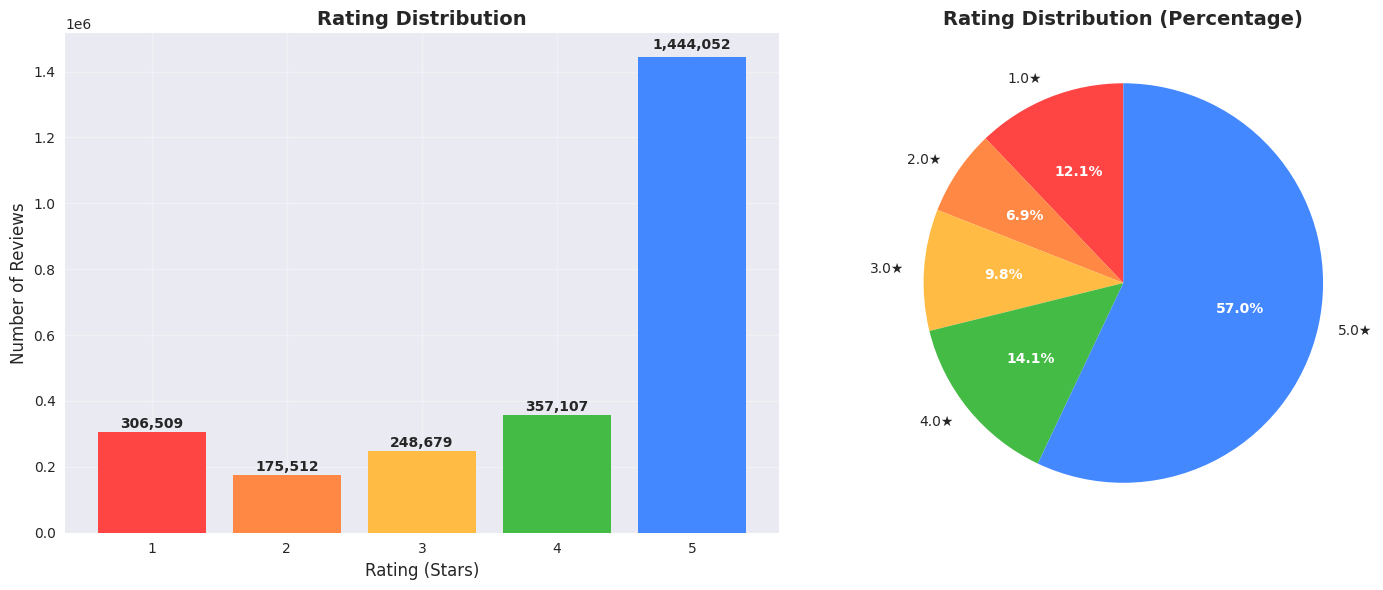


💡 KEY INSIGHTS:
   • Average rating: 3.97/5.0 stars
   • 71.1% of reviews are 4+ stars (positive)
   • 19.0% of reviews are 2 stars or below (negative)
   • Rating distribution shows positive sentiment overall


In [7]:
# Visualize rating distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of rating distribution
rating_df_pandas = rating_df.to_pandas()
bars = ax1.bar(rating_df_pandas['rating'], rating_df_pandas['count'], 
               color=['#ff4444', '#ff8844', '#ffbb44', '#44bb44', '#4488ff'])
ax1.set_title('Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rating (Stars)', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Pie chart of rating percentages
colors = ['#ff4444', '#ff8844', '#ffbb44', '#44bb44', '#4488ff']
wedges, texts, autotexts = ax2.pie(rating_df_pandas['percentage'], 
                                   labels=[f'{r}★' for r in rating_df_pandas['rating']],
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Rating Distribution (Percentage)', fontsize=14, fontweight='bold')

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# Display key insights
avg_rating = rating_stats.to_pandas().iloc[0, 0]
high_ratings_pct = rating_df.filter(pl.col('rating') >= 4.0)['percentage'].sum()
low_ratings_pct = rating_df.filter(pl.col('rating') <= 2.0)['percentage'].sum()

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Average rating: {avg_rating:.2f}/5.0 stars")
print(f"   • {high_ratings_pct:.1f}% of reviews are 4+ stars (positive)")
print(f"   • {low_ratings_pct:.1f}% of reviews are 2 stars or below (negative)")
print(f"   • Rating distribution shows {'positive' if avg_rating >= 3.5 else 'mixed'} sentiment overall")


## 4. Temporal Analysis

Analyze review patterns over time to identify trends, seasonality, and temporal patterns.


In [8]:
# Temporal analysis using SQL (calculating dates from timestamp)
print("📅 TEMPORAL ANALYSIS")
print("="*50)

# Reviews by year
yearly_reviews_query = """
SELECT 
    toYear(toDate(timestamp / 1000)) as review_year,
    COUNT(*) as review_count,
    AVG(rating) as avg_rating,
    COUNT(DISTINCT asin) as unique_products,
    COUNT(DISTINCT user_id) as unique_users
FROM amazon.reviews 
WHERE timestamp IS NOT NULL
GROUP BY toYear(toDate(timestamp / 1000)) 
ORDER BY review_year
"""

yearly_data = clickhouse.sql_query(sql=yearly_reviews_query)
print("📊 Reviews by Year:")
for i in range(len(yearly_data)):
    year = yearly_data.to_pandas().iloc[i, 0]
    count = yearly_data.to_pandas().iloc[i, 1]
    rating = yearly_data.to_pandas().iloc[i, 2]
    products = yearly_data.to_pandas().iloc[i, 3]
    users = yearly_data.to_pandas().iloc[i, 4]
    print(f"   {int(year)}: {count:,} reviews, avg rating: {rating:.2f}, {products:,} products, {users:,} users")

print()

# Reviews by month (across all years)
monthly_reviews_query = """
SELECT 
    toMonth(toDate(timestamp / 1000)) as review_month,
    COUNT(*) as review_count,
    AVG(rating) as avg_rating
FROM amazon.reviews 
WHERE timestamp IS NOT NULL
GROUP BY toMonth(toDate(timestamp / 1000)) 
ORDER BY review_month
"""

monthly_data = clickhouse.sql_query(sql=monthly_reviews_query)
print("📊 Reviews by Month (Average across years):")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(len(monthly_data)):
    month = monthly_data.to_pandas().iloc[i, 0]
    count = monthly_data.to_pandas().iloc[i, 1]
    rating = monthly_data.to_pandas().iloc[i, 2]
    month_idx = int(month) - 1
    print(f"   {month_names[month_idx]}: {count:,} reviews, avg rating: {rating:.2f}")

print()

# Top months for reviews
top_months_query = """
SELECT 
    toMonth(toDate(timestamp / 1000)) as review_month,
    COUNT(*) as review_count
FROM amazon.reviews 
WHERE timestamp IS NOT NULL
GROUP BY toMonth(toDate(timestamp / 1000)) 
ORDER BY review_count DESC
LIMIT 5
"""

top_months = clickhouse.sql_query(sql=top_months_query)
print("🔥 Top 5 Months by Review Volume:")
for i in range(len(top_months)):
    month = top_months.to_pandas().iloc[i, 0]
    count = top_months.to_pandas().iloc[i, 1]
    month_idx = int(month) - 1
    print(f"   {i+1}. {month_names[month_idx]}: {count:,} reviews")

# Convert to Polars DataFrames for visualization
yearly_df = pl.DataFrame({
    'year': [yearly_data.to_pandas().iloc[i, 0] for i in range(len(yearly_data))],
    'review_count': [yearly_data.to_pandas().iloc[i, 1] for i in range(len(yearly_data))],
    'avg_rating': [yearly_data.to_pandas().iloc[i, 2] for i in range(len(yearly_data))],
    'unique_products': [yearly_data.to_pandas().iloc[i, 3] for i in range(len(yearly_data))],
    'unique_users': [yearly_data.to_pandas().iloc[i, 4] for i in range(len(yearly_data))]
})

monthly_df = pl.DataFrame({
    'month': [monthly_data.to_pandas().iloc[i, 0] for i in range(len(monthly_data))],
    'month_name': [month_names[int(monthly_data.to_pandas().iloc[i, 0])-1] for i in range(len(monthly_data))],
    'review_count': [monthly_data.to_pandas().iloc[i, 1] for i in range(len(monthly_data))],
    'avg_rating': [monthly_data.to_pandas().iloc[i, 2] for i in range(len(monthly_data))]
})

print(f"\n📊 Temporal data loaded into Polars DataFrames:")
print(f"   Yearly data: {yearly_df.shape}")
print(f"   Monthly data: {monthly_df.shape}")


📅 TEMPORAL ANALYSIS
📊 Reviews by Year:
   2002: 6 reviews, avg rating: 4.83, 5 products, 6 users
   2003: 10 reviews, avg rating: 4.50, 10 products, 10 users
   2004: 38 reviews, avg rating: 3.92, 26 products, 34 users
   2005: 70 reviews, avg rating: 3.74, 60 products, 67 users
   2006: 160 reviews, avg rating: 4.06, 120 products, 149 users
   2007: 892 reviews, avg rating: 4.18, 673 products, 829 users
   2008: 1,204 reviews, avg rating: 4.27, 819 products, 1,122 users
   2009: 1,449 reviews, avg rating: 4.26, 1,060 products, 1,348 users
   2010: 1,900 reviews, avg rating: 4.16, 1,450 products, 1,810 users
   2011: 3,039 reviews, avg rating: 4.11, 2,184 products, 2,908 users
   2012: 7,513 reviews, avg rating: 4.18, 4,216 products, 7,114 users
   2013: 23,261 reviews, avg rating: 4.13, 9,888 products, 21,820 users
   2014: 60,444 reviews, avg rating: 4.09, 22,355 products, 55,534 users
   2015: 129,765 reviews, avg rating: 4.10, 46,180 products, 116,837 users
   2016: 292,420 reviews

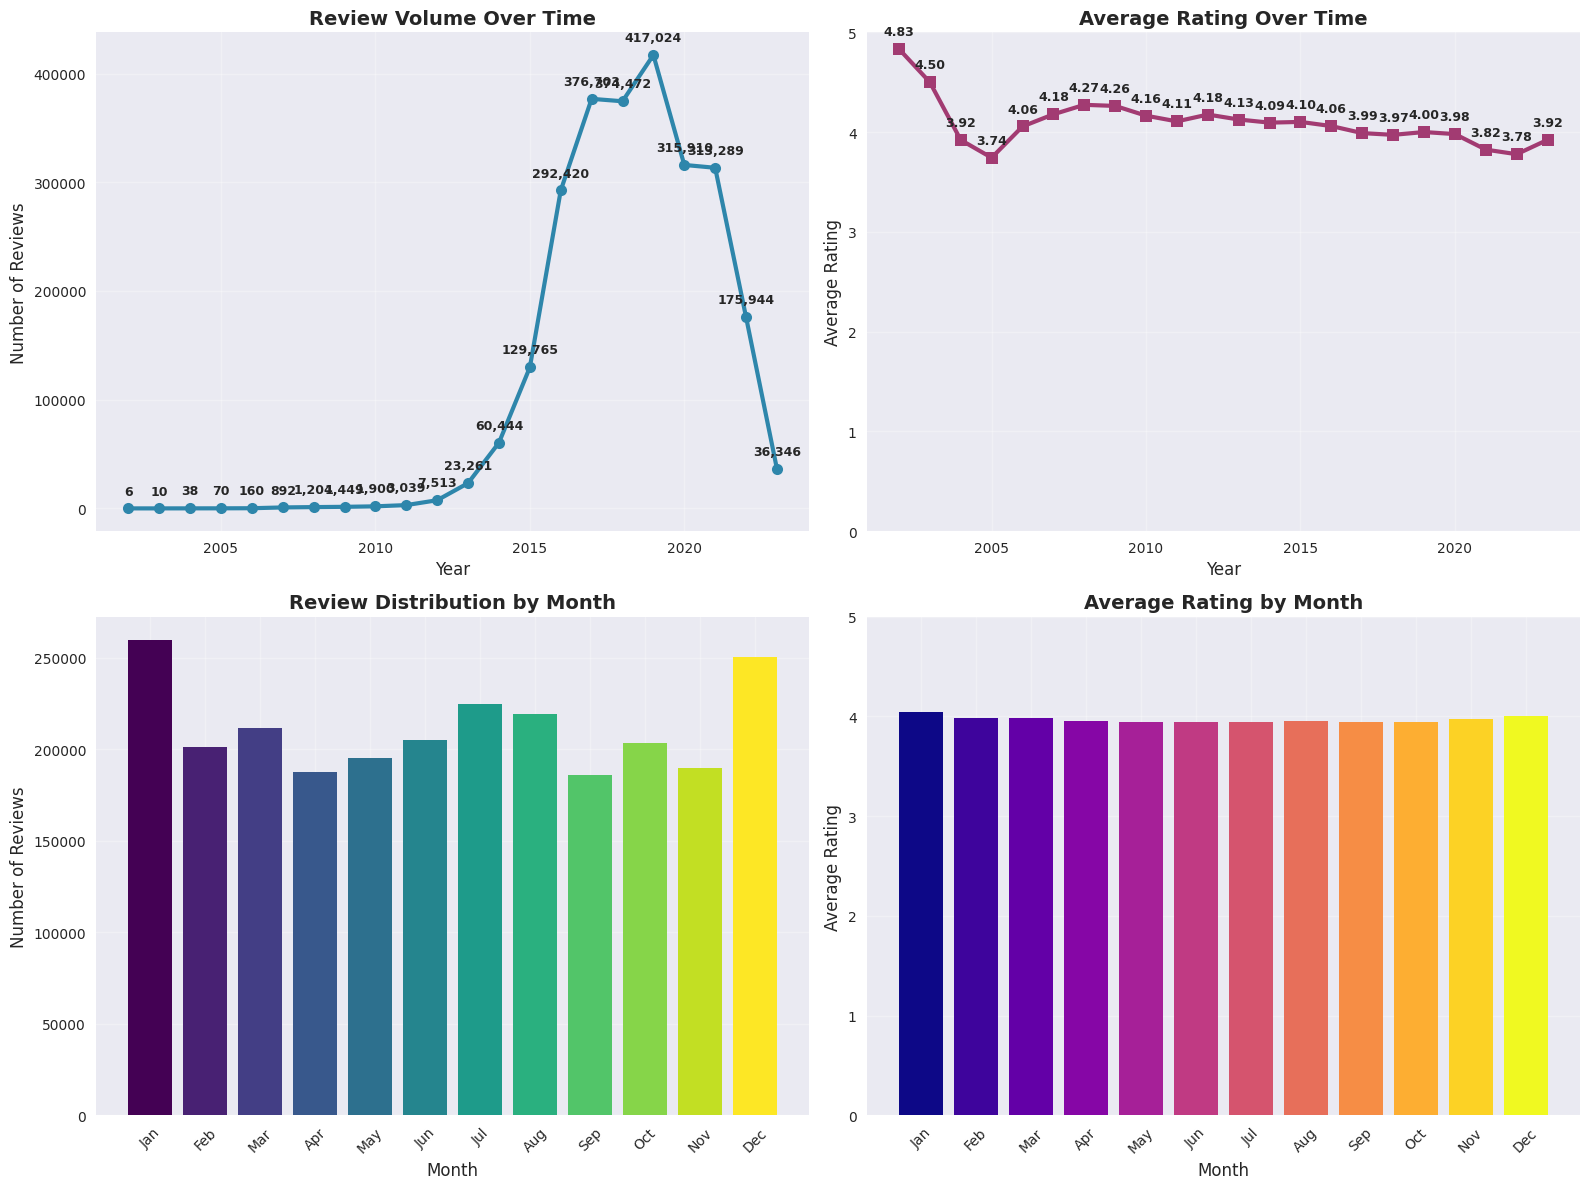


💡 TEMPORAL INSIGHTS:
   • Peak review year: 2019
   • Peak review month: Jan
   • Rating trend: declining over time
   • Total years covered: 22 years
   • Average reviews per year: 115084


In [9]:
# Visualize temporal patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Reviews over time (yearly)
yearly_pandas = yearly_df.to_pandas()
ax1.plot(yearly_pandas['year'], yearly_pandas['review_count'], 
         marker='o', linewidth=3, markersize=8, color='#2E86AB')
ax1.set_title('Review Volume Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')

# Add value labels
for i, (year, count) in enumerate(zip(yearly_pandas['year'], yearly_pandas['review_count'])):
    ax1.annotate(f'{count:,}', (year, count), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 2. Average rating over time
ax2.plot(yearly_pandas['year'], yearly_pandas['avg_rating'], 
         marker='s', linewidth=3, markersize=8, color='#A23B72')
ax2.set_title('Average Rating Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Average Rating', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 5)

# Add value labels
for i, (year, rating) in enumerate(zip(yearly_pandas['year'], yearly_pandas['avg_rating'])):
    ax2.annotate(f'{rating:.2f}', (year, rating), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 3. Monthly review distribution
monthly_pandas = monthly_df.to_pandas()
bars = ax3.bar(monthly_pandas['month_name'], monthly_pandas['review_count'], 
               color=plt.cm.viridis(np.linspace(0, 1, 12)))
ax3.set_title('Review Distribution by Month', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Number of Reviews', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Monthly average ratings
bars2 = ax4.bar(monthly_pandas['month_name'], monthly_pandas['avg_rating'], 
                color=plt.cm.plasma(np.linspace(0, 1, 12)))
ax4.set_title('Average Rating by Month', fontsize=14, fontweight='bold')
ax4.set_xlabel('Month', fontsize=12)
ax4.set_ylabel('Average Rating', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 5)

plt.tight_layout()
plt.show()

# Temporal insights using Polars
peak_year = yearly_df.sort('review_count', descending=True).head(1)['year'][0]
peak_month = monthly_df.sort('review_count', descending=True).head(1)['month_name'][0]
rating_trend = yearly_df.sort('year')['avg_rating']

print(f"\n💡 TEMPORAL INSIGHTS:")
print(f"   • Peak review year: {peak_year}")
print(f"   • Peak review month: {peak_month}")
print(f"   • Rating trend: {'improving' if rating_trend[-1] > rating_trend[0] else 'declining'} over time")
print(f"   • Total years covered: {len(yearly_df)} years")
print(f"   • Average reviews per year: {yearly_df['review_count'].mean():.0f}")
